In [1]:
%pip install chardet geopandas matplotlib numpy pandas scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import chardet
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pyproj
import scipy.stats as stats

In [3]:
# Data files:
ROOT_DIR = pathlib.Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data"

In [4]:
def latest(path: pathlib.Path) -> pathlib.Path:
    """Return the latest file that matches the glob. Assumes the filenames only differ by a date, which is encoded as YYYY-MM-DD."""
    return max(path.parent.glob(path.name), key=lambda candidate: candidate.name)

# Process PHS Seven Day Average Data

In [5]:
# Data files:
AVG_DATA_FILE = latest(DATA_DIR / "PHS" / "Seven day average of wastewater sample (Retrieved *-*-*).csv")


In [6]:
# Determine the encoding of the input file:
with open(AVG_DATA_FILE, 'rb') as data:
    AVG_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [7]:
# Read the data:
AVG_DATA = pd.read_csv(AVG_DATA_FILE, encoding=AVG_DATA_ENCODING, sep=',')

# Process SEPA RNA Monitoring Data

In [8]:
# Data files:
RNA_DATA_FILE = latest(DATA_DIR / "SEPA" / "Wastewater" / "RNAMonitoring_Public - Result Description - N1 Gene, Reported Value - N1 Gene (gc-l), Days Since (Retrieved *-*-*).csv")

In [9]:
# Determine the encoding of the input file:
with open(RNA_DATA_FILE, 'rb') as data:
    RNA_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [10]:
# Read the data:
rna_data = pd.read_csv(RNA_DATA_FILE, encoding=RNA_DATA_ENCODING, sep='\t')

In [11]:
# Column names:
HEALTH_AREA = 'Health Area'
SITE_NAME = 'Site Name'
POPULATION_SIZE = 'Population'
DATE = 'Date'
VALUE = 'Reported Value - N1 Gene (gc/l)'
VALUE_PER_1000 = 'Reported Value - N1 Gene per 1000 People (gc/l)'
VALUE_PER_PERSON = 'Reported Value - N1 Gene per person (gc/l)'

# Column values:
SITE_NAMES = rna_data[SITE_NAME].unique()
HEALTH_AREA_GGC = 'Greater Glasgow and Clyde'

# Outliers - number of standard deviations:
OUTLIER_STD_DEV = 3

In [12]:
# Check that each sample was taken on a different date:
for site_name in SITE_NAMES:
    assert rna_data[rna_data[SITE_NAME] == site_name][DATE].is_unique

In [13]:
# Remove outliers:
rna_data = rna_data[np.abs(stats.zscore(rna_data[VALUE])) < OUTLIER_STD_DEV]

In [14]:
# Remove samples without specified population:
rna_data = rna_data[rna_data[POPULATION_SIZE] != '(Empty)']

In [26]:
# Convert the date:
def parse_datetime(date):
    if not isinstance(date, datetime.datetime):
        month, day, year = map(int, date.split("/"))
        return datetime.datetime(year, month, day)
    else:
        return date

# Create a datetime index:
rna_data[DATE] = pd.DatetimeIndex(rna_data[DATE].map(parse_datetime))
rna_data.set_index(DATE, inplace=True)

In [27]:
# Convert the population size:
def parse_population_size(population_size):
    try:
        return int(population_size)
    except ValueError:
        return None

# Parse the population size:
rna_data[POPULATION_SIZE] = rna_data[POPULATION_SIZE].map(parse_population_size)

# Add value per person:
rna_data[VALUE_PER_PERSON] = rna_data[VALUE] / rna_data[POPULATION_SIZE]

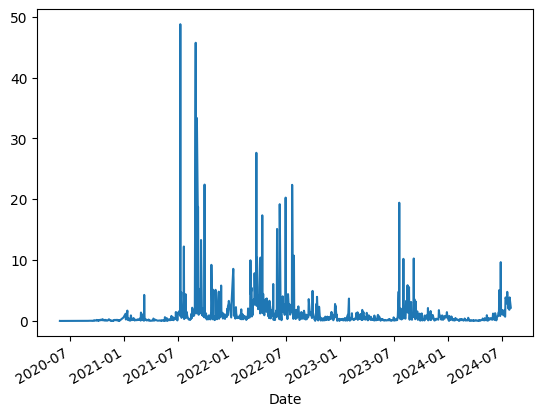

In [73]:
# Plot the value per person for the Greater Glasow and Clyde area:
# NOTE: The y-axis plots Gene copies per liter per person per day.
_ = rna_data[rna_data[HEALTH_AREA] == HEALTH_AREA_GGC].groupby(DATE)[VALUE_PER_PERSON].mean().plot()

# Visualise SEPA RNA Monitoring Data As Choropleth

In [74]:
# Data files:
HEALTH_BOARD_MAP_PROJ_FILE = DATA_DIR / "SG_NHS_HealthBoards_2019" / "SG_NHS_HealthBoards_2019.prj"
HEALTH_BOARD_MAP_SHAPE_FILE = DATA_DIR / "SG_NHS_HealthBoards_2019" / "SG_NHS_HealthBoards_2019.shp"

In [75]:
# Read the data:
health_board_crs = pyproj.CRS.from_wkt(HEALTH_BOARD_MAP_PROJ_FILE.read_text())
health_board_map = gpd.read_file(HEALTH_BOARD_MAP_SHAPE_FILE).set_crs(health_board_crs)

## Visualise Population per NHS Health Board

In [76]:
# Summarise population data per NHS health board:
population_data = (
    rna_data[[HEALTH_AREA, SITE_NAME, POPULATION_SIZE]]
        .set_index(HEALTH_AREA)
        .drop_duplicates()
        .groupby(HEALTH_AREA)
        .sum(POPULATION_SIZE)
)

In [77]:
# Merge the NHS health board map data with the population data:
health_board_population_map_data = health_board_map.set_index('HBName').join(population_data)

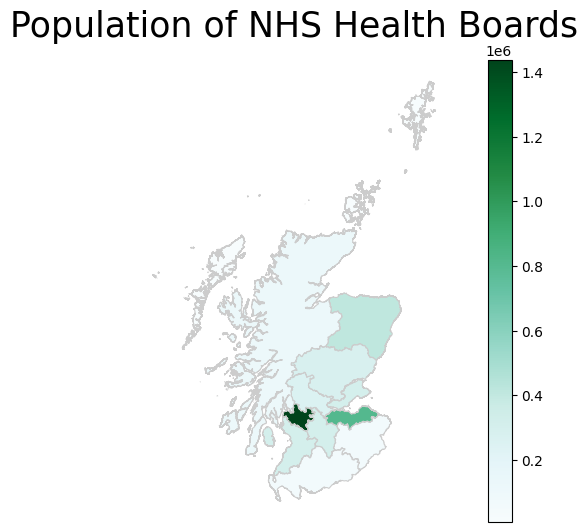

In [78]:
# Plot the population of each NHS health board as a choropleth:
POPULATION_SIZE_MIN = population_data[POPULATION_SIZE].min()
POPULATION_SIZE_MAX = population_data[POPULATION_SIZE].max()

fig, ax = plt.subplots(1, figsize=(10, 6))

# Plot figure:
health_board_population_map_data.plot(
    column=POPULATION_SIZE,
    cmap='BuGn',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
)

# Remove the axis:
ax.axis('off')

# Add a title:
ax.set_title(
    "Population of NHS Health Boards",
    fontdict={
        'fontsize': '25',
        'fontweight': '3'
    }
)

# Create colorbar as legend:
sm = plt.cm.ScalarMappable(
    cmap='BuGn',
    norm=plt.Normalize(vmin=POPULATION_SIZE_MIN, vmax=POPULATION_SIZE_MAX)
)

# Add empty array as data range
sm._A = []

# Add colorbar to figure
cbar = fig.colorbar(sm, ax=ax)

## Visualise Rainfall Stations on NHS Health Boards

In [79]:
# Data files:
RAINFALL_STATIONS_FILE = DATA_DIR / "SEPA" / "Rainfall" / "stations.json"

In [80]:
# Read the data:
rainfall_stations = pd.read_json(RAINFALL_STATIONS_FILE)

In [81]:
# Extract the points:
rainfall_station_points = gpd.GeoDataFrame(
  geometry=gpd.points_from_xy(rainfall_stations["station_longitude"], rainfall_stations["station_latitude"])
).set_crs(epsg=4326).to_crs(health_board_crs)

Text(0.5, 1.0, 'SEPA Rainfall Stations')

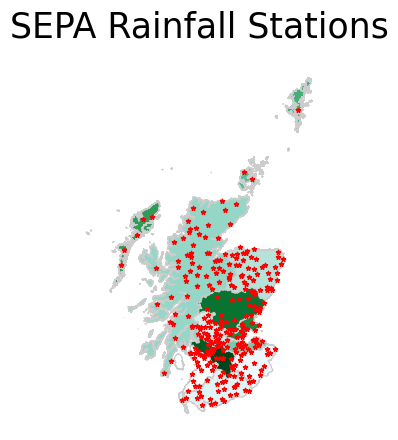

In [82]:
fig, ax = plt.subplots()

# health_board_map = health_board_map.to_crs(epsg=4326)
health_board_map.plot(
  cmap='BuGn',
  linewidth=0.8,
  ax=ax,
  edgecolor='0.8',
)
rainfall_station_points.plot(
  ax=ax,
  markersize=10,
  color="red",
  marker="*",
)

# Remove the axis:
ax.axis('off')

# Add a title:
ax.set_title(
    "SEPA Rainfall Stations",
    fontdict={
        'fontsize': '25',
        'fontweight': '3'
    }
)